# **Geometric Brownian Motion**
---
- stochastic process to help better define and expound upon Black-Scholes Model 

- [Medium?](https://medium.com/analytics-vidhya/modelling-geometric-brownian-motion-in-python-b65462cc2c1d)
- [Github?](https://github.com/yhilpisch/py4fi2nd/tree/master/code/dx)

### Import *.py* Libraries

In [2]:
# only shows data first time - restart kernel 
#import CONFIG as c
#import BLACK_SCHOLES as bs

### Import Libraries

In [3]:
import pandas as pd
import numpy as np 
import datetime as dt

import matplotlib.pyplot as plt

---
---
## Stochastic Differential Equation: 
---
---
#### Function: `dSt = r*Stdt + sigma*StdZt`
##### Variables: 
> - St: index level at date *t*
> - r: risk-free rate
> - sigma: volatility 
> - Z: standard normally distributed random variable 

In [4]:
# Class to Model Market Environment Relevant for Valuation 
class MarketEnvironment(object): 
    def __init__(self, name, pricing_date): 
        self.name = name
        self.pricing_date = pricing_date
        self.constants = {}
        self.lists = {}
        self.curves = {}
    
    # Add Constant (Model Parameter)
    def add_constant(self,key,constant): 
        self.constants[key] = constant 
    def get_constant(self,key): 
        return self.constants[key]
    
    # Add List (Underlying)
    def add_list(self, key, list_object): 
        self.lists[key] = list_object
    def get_list(self, key):
        return self.lists[key]
    
    # Add Market Curve
    def add_curve(self, key, curve): 
        self.curves[key] = curve
    def get_curve(self, key): 
        return self.curves[key]
    
    # Adds and Overwrites Whole Market Environment 
    def add_environment(self, env): 
        for key in env.constants: 
            self.constants[key] = env.constants[key]
        for key in env.lists: 
            self.lists[key] = env.lists[key]
        for key in env.curves: 
            self.curves[key] = env.curves[key]

In [5]:
# Simulation Class to Simulate Various Models
class SimulationClass(object): 
    def __init__(self, name, mar_env, corr): 
        try: 
            self.name = name
            self.pricing_date = mar_env.pricing_date
            self.initial_value = mar_env.get_constant('initial_value')
            self.volatility = mar_env.get_constant('volatility')
            self.final_date = mar_env.get_constant('final_date')
            self.currency = mar_env.get_constant('currency')
            self.frequency = mar_env.get_constant('frequency')
            self.paths = mar_env.get_constant('paths')
            self.discount_curve = mar_env.get_curve('discount_curve')
        
            try: 
                self.time_grid = mar_env.get_list('time_grid')
            except: 
                self.time_grid = None
        
            try: 
                self.specialD = mar_env.get_list('specialD')
            except: 
                self.specialD = []
        
            self.instrument_values = None
            self.correlated = corr
            if corr is True: 
                self.cholesky_matrix = mar_env.get_list('cholesky_matrix')
                self.rn_set = mar_env.get_list('rn_set')[self.name]
                self.random_numbers = mar_env.get_list('random_numbers')
        except: 
            print("Error Parsing Market Environment")
            
            
        
    def generate_time_grid(self): 
        start = self.pricing_date
        end = self.final_date
        
        time_grid = pd.date_range(start=start, end=end, freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        
        if start not in time_grid: 
            time_grid.insert(0,start)
        if end not in time_grid:
            time_grid.append(end)
        if len(self.specialD) > 0: 
            time_grid.extend(self.specialD)
            time_grid = list(set(time_grid))
            time_grid.sort()
        self.time_grid = np.array(time_grid) 
        
    # Sending to GeometricBrownianMotion Class via `self.generate_paths`
    def get_instrument_values(self, fixed_seed=True): 
        if self.instrument_values is None: 
            # only initiate simulation of no instrument values 
            self.generate_paths(fixed_seed=fixed_seed, day_count=365.)
        elif fixed_seed is False: 
            # only initiate resimulation when fixed_seed=False
            self.generate_paths(fixed_seed=fixed_seed, day_count=365.)
        return self.instrument_values

In [6]:
# Generates Simulated Paths
# Super Method -> calls SimulationClass
class GeometricBrownianMotion(SimulationClass): 
    ''' Class to Generate Simulated Paths Based on 
    Black-Scholes-Merton geometric Brownian Motion Model '''
    
    def __init__(self, name, mar_env, corr=False): 
        super(GeometricBrownianMotion, self).__init__(name, mar_env, corr)
        
    
    def update(self, initial_value=None, volatility=None, final_date=None): 
        if initial_value is not None: 
            self.initial_value = initial_value
        if volatility is not None: 
            self.volatility = volatility
        if final_date is not None: 
            self.final_date = final_date
        self.instrument_values = None
    
    def generate_paths(self, fixed_seed=False, day_count=365):
        if self.time_grid is None: 
            self.generate_time_grid()
        
        M = len(self.time_grid)
        J = self.paths
        paths = np.zeros((M,J))
        paths[0] = self.initial_value
        
        if not self.correlated: 
            rand = sn_random_numbers((1,M,J), fixed_seed=fixed_seed)
        else: 
            rand = self.random_numbers
        
        short_rate = self.discount_curve.short_rate
        for t in range(1, len(self.time_grid)):
            if not self.correlated:
                ran = rand[t]
            else: 
                ran = np.dot(self.cholesky_matrix, rand[:, t, :])
                ran = ran[self.rn_set]
            dt = (self.time_grid[t] - self.time_grid[t-1]).days/day_count
            paths[t] = paths[t-1] * np.exp((short_rate - 0.5 * self.volatility**2) * dt + self.volatility*np.sqrt(dt)*ran)
        self.instrument_values = paths 

In [7]:
class ConstantShortRate(object):
    
    def __init__(self, name, short_rate): 
        self.name=name
        self.short_rate = short_rate 
        if short_rate < 0: 
            raise ValueError("Negative Short Rate")
    
    def get_discount_factors(self, date_list, dtobjects=True):
        
        def get_year_deltas(date_list, day_count=365): 
            start = min(date_list)
            delta_list = [(date - start).days / day_count for date in date_list]
            return np.array(delta_list)

        if dtobjects is True:
            dlist = get_year_deltas(date_list)
        else:
            dlist = np.array(date_list)
        dflist = np.exp(self.short_rate * -dlist)
        return np.array((date_list, dflist)).T

In [8]:
def get_year_deltas(date_list, day_count=365): 
    start = min(date_list)
    delta_list = [(date - start).days / day_count for date in date_list]
    return np.array(delta_list)

# returns array of random numbers that are normally distributed 
def sn_random_numbers(shape, antithetic=True, moment_matching=True, fixed_seed=False):
    '''input -> shape: tuple(o,n,m) of (pesudo) random numbers
    Results
    =======
    ran: tuple of (o,n,m) PseudoRandom Numbers'''
    if fixed_seed:
        np.random.seed(1000)
    if antithetic: 
        ran = np.random.standard_normal((shape[0],shape[1],shape[2] // 2))
        ran = np.concatenate((ran, -ran), axis=2)
    else: 
        ran = np.random.standard_normal(shape)
    if moment_matching:
        ran = ran - np.mean(ran)
        ran = ran / np.std(ran)
    if shape[0] == 1:
        return ran[0]
    else: 
        return ran

# Standard Normal Distribution of Random Numbers

In [9]:
fak = False
truf = True
snrnFFT = sn_random_numbers((2,2,2), antithetic=fak, moment_matching=fak, fixed_seed=truf)
print('-------------------------------------------- \nTuple of SNRN for {},{},{}: \n-------------------------------------------- \n{}\n'.format(fak,fak,truf,snrnFFT))

meanSNRNfft = round(snrnFFT.mean(), 6)
stdSNRNfft = round(snrnFFT.std(), 6)
print('\nMean of SNRN: {} \nSTD of SNRN: {} \n'.format(meanSNRNfft, stdSNRNfft))

snrnFTT = sn_random_numbers((2,2,2), antithetic=False, moment_matching=True, fixed_seed=True)
print('-------------------------------------------- \nTuple of SNRN for {},{},{}: \n-------------------------------------------- \n{}\n'.format(fak,truf,truf,snrnFTT))

meanSNRN2 = round(snrnFTT.mean(), 6)
stdSNRN2 = round(snrnFTT.std(), 6)
print('\n2 Mean of SNRN: {} \n2 STD of SNRN: {}'.format(meanSNRN2, stdSNRN2))

-------------------------------------------- 
Tuple of SNRN for False,False,True: 
-------------------------------------------- 
[[[-0.8044583   0.32093155]
  [-0.02548288  0.64432383]]

 [[-0.30079667  0.38947455]
  [-0.1074373  -0.47998308]]]


Mean of SNRN: -0.045429 
STD of SNRN: 0.451876 

-------------------------------------------- 
Tuple of SNRN for False,True,True: 
-------------------------------------------- 
[[[-1.67972865  0.81075283]
  [ 0.04413963  1.52641815]]

 [[-0.56512826  0.96243813]
  [-0.13722505 -0.96166678]]]


2 Mean of SNRN: -0.0 
2 STD of SNRN: 1.0


# Risk-Neutral Discounting

In [10]:
dates = [dt.datetime(2020, 1, 1), dt.datetime(2020, 7, 1), dt.datetime(2021, 1, 1)]
print('({} - {})/365 = {}'.format(dates[1],dates[0],(dates[1] - dates[0]).days/365))
print('({} - {})/365 = {} \n'.format(dates[2],dates[1],(dates[2] - dates[1]).days/365))

csr = ConstantShortRate('csr', 0.05)
print('Constant Short Rate Discount Factors: \n {} \n'.format(csr.get_discount_factors(dates)))

deltas = get_year_deltas(dates)
print('Using `int` values rather than `datetime objects`: (DELTAS,DTOBJECTS=FALSE)')
print('Deltas: \n {}'.format(deltas))
print('Constant Short Rate Discount Factors:\n{}\n '.format(csr.get_discount_factors(deltas,dtobjects=False)))

(2020-07-01 00:00:00 - 2020-01-01 00:00:00)/365 = 0.4986301369863014
(2021-01-01 00:00:00 - 2020-07-01 00:00:00)/365 = 0.5041095890410959 

Constant Short Rate Discount Factors: 
 [[datetime.datetime(2020, 1, 1, 0, 0) 1.0]
 [datetime.datetime(2020, 7, 1, 0, 0) 0.9753767163648953]
 [datetime.datetime(2021, 1, 1, 0, 0) 0.9510991280247174]] 

Using `int` values rather than `datetime objects`: (DELTAS,DTOBJECTS=FALSE)
Deltas: 
 [0.         0.49863014 1.00273973]
Constant Short Rate Discount Factors:
[[0.         1.        ]
 [0.49863014 0.97537672]
 [1.00273973 0.95109913]]
 


# Build Market Environment

In [11]:
me_gbm = MarketEnvironment('me_gbm', dt.datetime(2020,1,1))

me_gbm.add_constant('initial_value',36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2020,12,31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 10000)

csr = ConstantShortRate('csr', 0.06)
me_gbm.add_curve('discount_curve', csr)

print('Volatility: ', me_gbm.get_constant('volatility'))
print('Discount Curve: ', me_gbm.get_curve('discount_curve').short_rate)

Volatility:  0.2
Discount Curve:  0.06


# Geometric Brownian Motion 

In [12]:
gbm = GeometricBrownianMotion('gbm', me_gbm)

In [13]:
gbm.generate_time_grid()
gbm.time_grid

array([datetime.datetime(2020, 1, 1, 0, 0),
       datetime.datetime(2020, 1, 31, 0, 0),
       datetime.datetime(2020, 2, 29, 0, 0),
       datetime.datetime(2020, 3, 31, 0, 0),
       datetime.datetime(2020, 4, 30, 0, 0),
       datetime.datetime(2020, 5, 31, 0, 0),
       datetime.datetime(2020, 6, 30, 0, 0),
       datetime.datetime(2020, 7, 31, 0, 0),
       datetime.datetime(2020, 8, 31, 0, 0),
       datetime.datetime(2020, 9, 30, 0, 0),
       datetime.datetime(2020, 10, 31, 0, 0),
       datetime.datetime(2020, 11, 30, 0, 0),
       datetime.datetime(2020, 12, 31, 0, 0)], dtype=object)

In [14]:
paths_1 = gbm.get_instrument_values(fixed_seed=True)
%time paths_1

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


array([[36.        , 36.        , 36.        , ..., 36.        ,
        36.        , 36.        ],
       [37.40294432, 38.1202286 , 34.39982796, ..., 36.25237338,
        35.08385942, 39.66803061],
       [39.56215864, 42.33469811, 32.40538454, ..., 34.83629018,
        33.63662765, 37.65510279],
       ...,
       [40.53366758, 33.50636556, 23.49685724, ..., 37.85092447,
        30.1215691 , 30.44622198],
       [42.52703398, 36.99482853, 21.88510923, ..., 36.01377456,
        30.90661364, 30.71201021],
       [43.81111399, 37.87614657, 24.09965746, ..., 36.26314754,
        28.13750711, 29.03790066]])

In [15]:
paths_1.round(3)

array([[36.   , 36.   , 36.   , ..., 36.   , 36.   , 36.   ],
       [37.403, 38.12 , 34.4  , ..., 36.252, 35.084, 39.668],
       [39.562, 42.335, 32.405, ..., 34.836, 33.637, 37.655],
       ...,
       [40.534, 33.506, 23.497, ..., 37.851, 30.122, 30.446],
       [42.527, 36.995, 21.885, ..., 36.014, 30.907, 30.712],
       [43.811, 37.876, 24.1  , ..., 36.263, 28.138, 29.038]])

In [16]:
gbm.update(volatility=0.5)
paths_2 = gbm.get_instrument_values(fixed_seed=False)
%time paths_2

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


array([[36.        , 36.        , 36.        , ..., 36.        ,
        36.        , 36.        ],
       [41.87310491, 31.29230817, 27.88999826, ..., 30.77384551,
        48.86104096, 33.30811772],
       [31.87295478, 34.80217263, 32.71205368, ..., 32.62889774,
        46.8679299 , 29.98921096],
       ...,
       [30.78876449, 46.90180319, 37.87610361, ..., 28.52605889,
        35.42742571, 28.79081566],
       [40.7734584 , 52.8666956 , 35.36814941, ..., 28.48777994,
        31.70245821, 26.56219073],
       [47.32239974, 66.44999404, 23.97060213, ..., 26.85504505,
        36.23870776, 29.02560962]])

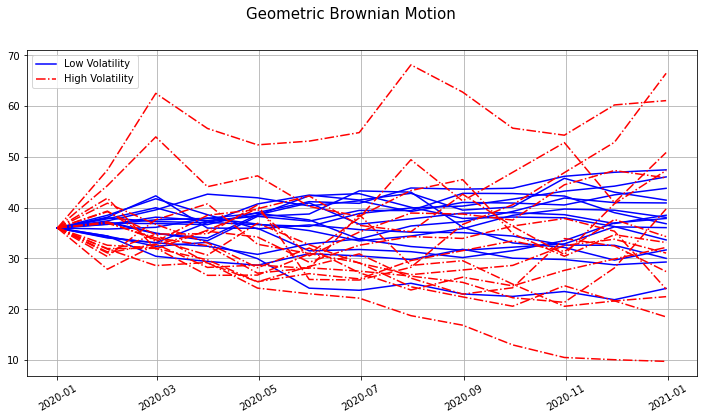

In [17]:
import matplotlib.pyplot as plt

filename = 'example'

plt.figure(figsize=(12,6))
p1 = plt.plot(gbm.time_grid, paths_1[:,:15], 'b')
p2 = plt.plot(gbm.time_grid, paths_2[:,:15], 'r-.')

plt.grid(True)
plt.legend([p1[0],p2[0]],['Low Volatility', 'High Volatility'],loc=2)
plt.suptitle("Geometric Brownian Motion",fontsize=15)
plt.xticks(rotation=30)

#plt.show()
plt.savefig('brownieCharts/png/{}.png'.format(filename)) #no title/tick marks
plt.savefig('brownieCharts/pdf/{}.pdf'.format(filename)) #title and tick marks
plt.savefig('brownieCharts/svg/{}.svg'.format(filename)) #able to zoom
plt.savefig('brownieCharts/jpeg/{}.jpeg'.format(filename)) #title and tick marks 